### Cell 1: Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os


### Cell 2: Load environment variables and set up database connection

In [3]:
# Load environment variables from .env file
load_dotenv()

# Set up the database connection using environment variables
db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(db_url)


### Cell 3: Fetch data from the database

In [5]:
# SQL Query to fetch the required data
query = """
SELECT
    c.customerid,
    SUM(s.totalprice) AS total_sales,
    COUNT(s.salesid) AS order_frequency
FROM
    customer c
JOIN
    sales s ON c.customerid = s.customerid
GROUP BY
    c.customerid
"""

# Load data from the database
df = pd.read_sql(query, engine)

# Inspect the first few rows of the data
df.head()


,customerid,total_sales,order_frequency
0,16592,3584.33,200
1,13527,1828.50,188
2,14173,222.34,23
3,12502,1511.32,91
4,14067,275.04,45


### Cell 4: Preprocess the data (normalize features)

In [6]:
# Preprocess the data: Normalize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['total_sales', 'order_frequency']])


### Cell 5: Apply K-Means clustering

In [7]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Inspect the cluster centers to understand their meaning
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers (total_sales, order_frequency):")
print(cluster_centers)


Cluster Centers (total_sales, order_frequency):
[[-0.16204836 -0.14299831]
 [19.16300539 24.74623533]
 [ 1.83081412  1.5117996 ]]


### Cell 6: Assign meaningful labels to clusters

In [8]:
# Assign meaning to the clusters based on the cluster centers
# Here, we assume:
# Cluster 0: High-Value Customers (higher total_sales and order_frequency)
# Cluster 1: Low-Value Customers (lower total_sales and order_frequency)
# Cluster 2: Moderate-Value Customers (moderate total_sales and order_frequency)

# Check the cluster centers and assign meaningful labels
if cluster_centers[0][0] > cluster_centers[1][0]:  # You can adjust the logic as needed
    cluster_labels = {
        0: 'High-Value Customers',
        1: 'Low-Value Customers',
        2: 'Moderate-Value Customers'
    }
else:
    cluster_labels = {
        0: 'Low-Value Customers',
        1: 'High-Value Customers',
        2: 'Moderate-Value Customers'
    }

# Add the cluster label to the customer data for better interpretation
df['Cluster Label'] = df['Cluster'].map(cluster_labels)

# Display the updated dataframe with cluster labels
df.head()


,customerid,total_sales,order_frequency,Cluster,Cluster Label
0,16592,3584.33,200,2,Moderate-Value Customers
1,13527,1828.50,188,0,Low-Value Customers
2,14173,222.34,23,0,Low-Value Customers
3,12502,1511.32,91,0,Low-Value Customers
4,14067,275.04,45,0,Low-Value Customers


### Cell 7: Visualize the clustering result

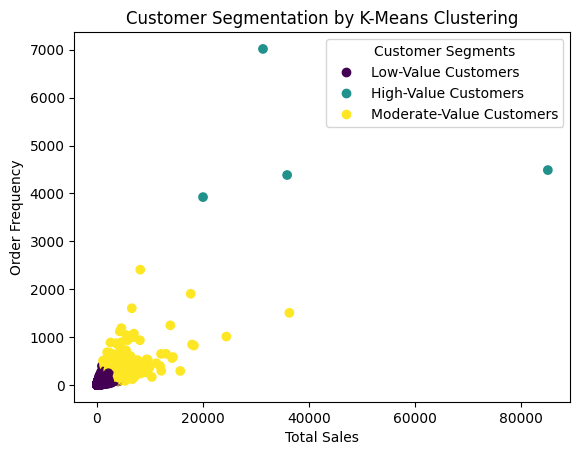

In [9]:
# Visualize the clustering result with color labels
scatter = plt.scatter(df['total_sales'], df['order_frequency'], 
                      c=df['Cluster'], cmap='viridis')

# Create a custom legend to show which color corresponds to which cluster
handles, _ = scatter.legend_elements()
legend_labels = [cluster_labels[i] for i in range(3)]
plt.legend(handles, legend_labels, title="Customer Segments")

# Label the axes and title
plt.xlabel('Total Sales')
plt.ylabel('Order Frequency')
plt.title('Customer Segmentation by K-Means Clustering')
plt.show()


### Cell 8: Save the K-Means model and scaler

In [10]:
# Save the K-Means model and scaler
joblib.dump(kmeans, 'customer_segmentation_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler as well


['scaler.pkl']

### Cell 9: Evaluate clustering performance

In [13]:
print("Evaluating clustering performance...")

silhouette_avg = silhouette_score(df_scaled, df['Cluster'])
print(f'\nSilhouette Score: {silhouette_avg:.4f}')

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(df_scaled, df['Cluster'])
print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(df_scaled, df['Cluster'])
print(f'Calinski-Harabasz Index: {calinski_harabasz:.4f}')


Evaluating clustering performance...

Silhouette Score: 0.7840
Davies-Bouldin Index: 0.5985
Calinski-Harabasz Index: 4710.2336
